In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm # Pakai tqdm standar agar stabil

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score)

# Konfigurasi tampilan
%matplotlib inline
tqdm.pandas() # Aktifkan progress bar pandas


In [21]:
# --- KONFIGURASI ---
MAX_FEATURES = 5000
TEST_SIZE = 0.2
RANDOM_STATE = 42

FILE_MANUAL = 'dataset_labelling_manual.csv'
FILE_FULL = 'dataset_tugas_purbaya_vs_srimulyani.csv'

factory = StemmerFactory()
stemmer = factory.create_stemmer()


In [29]:
# Import Stopword Factory dari Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# 1. SIAPKAN DAFTAR STOPWORDS
factory_sw = StopWordRemoverFactory()
stopwords_indo = factory_sw.get_stop_words()

# Tambahan stopwords manual (kata yang sering muncul tapi tidak penting di WordCloud)
more_stopwords = [
    'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar',
    'bikin', 'bilang', 'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 'si',
    'tau', 'tdk', 'tuh', 'utk', 'ya', 'jd', 'jgn', 'sdh', 'aja', 'n',
    't', 'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt', 'bukan', 'ini',
    'itu', 'ada', 'dan', 'dari', 'dia', 'ke', 'kita', 'mau', 'pada',
    'saya', 'kami', 'anda', 'mereka', 'semua', 'sudah', 'tapi', 'atau',
    'banyak', 'beberapa', 'biasa', 'bila', 'boleh', 'buat', 'bukan',
    'cukup', 'cuma', 'dapat', 'dari', 'depan', 'diri', 'dulu', 'enggak',
    'entah', 'hal', 'hampir', 'hanya', 'harus', 'hendak', 'ia', 'ingin',
    'ini', 'itu', 'jadi', 'jangan', 'jika', 'juga', 'justru', 'kalau',
    'kami', 'kamu', 'kan', 'kapan', 'karena', 'kata', 'ke', 'kembali',
    'kenapa', 'kepada', 'ketika', 'kita', 'lagi', 'lalu', 'lain', 'lama',
    'lewat', 'mana', 'mari', 'masih', 'mau', 'mengapa', 'mereka', 'maka',
    'menurut', 'mungkin', 'nanti', 'namun', 'nyaris', 'oleh', 'pada',
    'padahal', 'paling', 'para', 'pasti', 'per', 'pernah', 'pula', 'pun',
    'saat', 'saja', 'sambil', 'sampai', 'sana', 'sangat', 'saya', 'sebab',
    'bagai', 'seperti', 'sering', 'siapa', 'silakan', 'sini', 'suatu',
    'sudah', 'supaya', 'tadi', 'tak', 'tanpa', 'tapi', 'telah', 'tentang',
    'tentu', 'tepat', 'terhadap', 'tetapi', 'tiap', 'tidak', 'toh', 'tunjuk',
    'turut', 'untuk', 'waduh', 'wah', 'wahai', 'wong', 'yaitu', 'yakni', 'yang'
]

# 2. DAFTAR NAMA TOKOH (DIHAPUS AGAR TIDAK BIAS)
stopwords_tokoh = [
    'sri', 'mulyani', 'indrawati', 'bu sri', 'menkeu', 'menteri keuangan',
    'purbaya', 'yudhi', 'sadewa', 'pak purbaya', 'purbaya sadewa',
    'menteri', 'pak', 'bu', 'bapak', 'ibu', 'presiden', 'jokowi', 'prabowo'
]

# Gabungkan semua stopwords menjadi satu SET (agar pencarian cepat)
# Set otomatis menghapus duplikat
final_stopwords = set(stopwords_indo + more_stopwords + stopwords_tokoh)

# 3. KAMUS SLANG
slang_dict = {
    'yg': 'yang', 'gk': 'tidak', 'ga': 'tidak', 'gak': 'tidak', 'enggak': 'tidak',
    'bgt': 'banget', 'dlm': 'dalam', 'sy': 'saya', 'aku': 'saya', 'gw': 'saya',
    'gue': 'saya', 'lu': 'kamu', 'lo': 'kamu', 'anda': 'kamu', 'kalo': 'kalau',
    'kl': 'kalau', 'klo': 'kalau', 'dr': 'dari', 'dgn': 'dengan', 'krn': 'karena',
    'jd': 'jadi', 'jdi': 'jadi', 'sdh': 'sudah', 'udh': 'sudah', 'blm': 'belum',
    'tp': 'tapi', 'tpi': 'tapi', 'tak': 'tidak', 'tdk': 'tidak', 'jgn': 'jangan',
    'utk': 'untuk', 'aja': 'saja', 'aj': 'saja', 'lbh': 'lebih', 'sbg': 'sebagai',
    'bs': 'bisa', 'bisa': 'dapat', 'pd': 'pada', 'kmrn': 'kemarin', 'skrg': 'sekarang',
    'trs': 'terus', 'bkn': 'bukan', 'ok': 'oke', 'thx': 'terima kasih',
    'makasih': 'terima kasih', 'tks': 'terima kasih', 'gan': 'juragan',
    'kak': 'kakak', 'min': 'admin', 'tau': 'tahu', 'mw': 'mau', 'mo': 'mau',
    'lbh': 'lebih', 'memang': 'memang', 'emang': 'memang', 'kayak': 'seperti',
    'kyk': 'seperti', 'kek': 'seperti', 'bpk': 'Bapak'
}


def clean_text(text):
    """
    Pipeline: Lowercase -> Regex -> Slang -> Stopwords Removal -> Stemming
    """
    text = str(text).lower()

    # A. Regex Cleaning
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    final_words = []

    for word in words:
        # B. Normalisasi Slang
        word = slang_dict.get(word, word)

        # C. STOPWORD REMOVAL (Baru ditambahkan)
        # Jika kata ada di daftar stopwords, lewati/hapus
        if word in final_stopwords:
            continue

        # D. Hapus kata < 3 huruf (Double filter)
        if len(word) < 3:
            continue

        final_words.append(word)

    text = " ".join(final_words)

    # E. Stemming (Sastrawi)
    if len(text) > 0:
        text = stemmer.stem(text)

    return text


print("✓ Fungsi cleaning SIAP (Termasuk Stopword Removal).")

✓ Fungsi cleaning SIAP (Termasuk Stopword Removal).


➤ Memulai Cleaning & Stemming...


  0%|          | 0/315 [00:00<?, ?it/s]

100%|██████████| 1982/1982 [00:00<00:00, 31652.11it/s]


✓ Data Manual Bersih: 315 samples



C:\Users\alfit\AppData\Local\Temp\ipykernel_27120\1173736925.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=manual_df, palette='viridis')


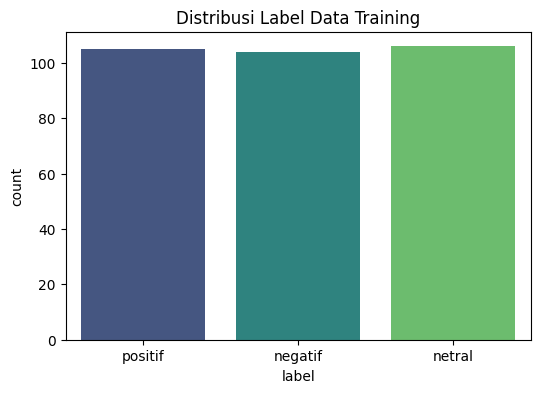

In [30]:
try:
    manual_df = pd.read_csv(FILE_MANUAL)
    full_df = pd.read_csv(FILE_FULL)

    # Bersihkan header
    manual_df.columns = manual_df.columns.str.strip()
    full_df.columns = full_df.columns.str.strip()

    print("➤ Memulai Cleaning & Stemming...")
    # Pakai progress_apply dari tqdm
    manual_df['clean_text'] = manual_df['text'].progress_apply(clean_text)
    full_df['clean_text'] = full_df['text'].progress_apply(clean_text)

    # Hapus duplikat & kosong
    manual_df = manual_df.drop_duplicates(subset=['text'])
    manual_df = manual_df[manual_df['clean_text'].str.len() > 0]

    print(f"\n✓ Data Manual Bersih: {len(manual_df)} samples")

    # Cek Distribusi Label
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=manual_df, palette='viridis')
    plt.title('Distribusi Label Data Training')
    plt.show()

except FileNotFoundError:
    print("❌ ERROR: File csv tidak ditemukan.")

➤ WordCloud: Seluruh Data


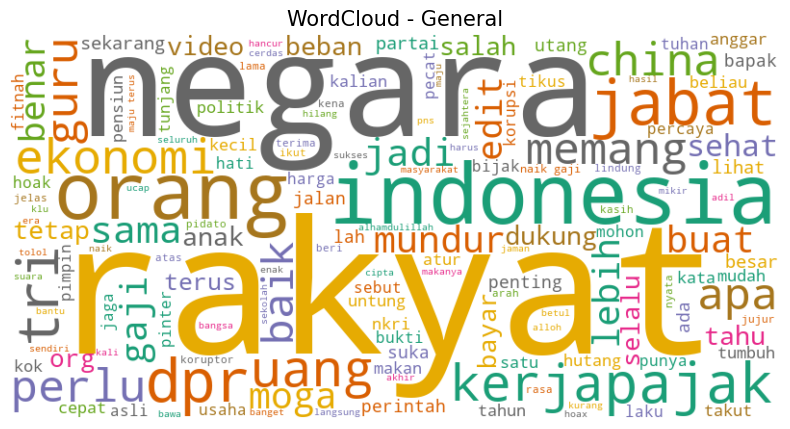

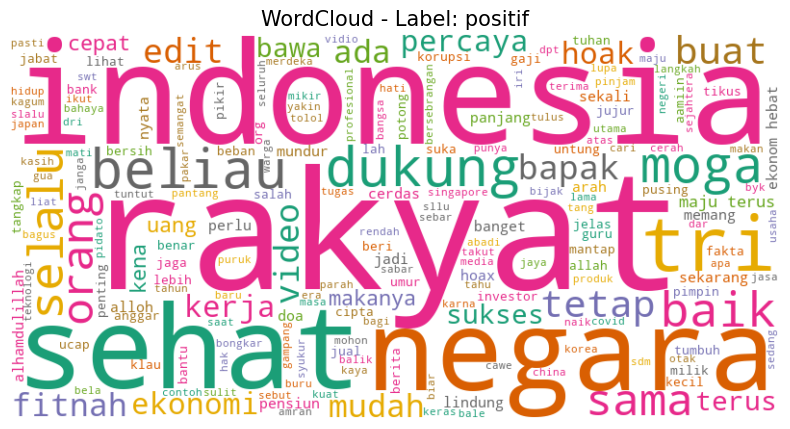

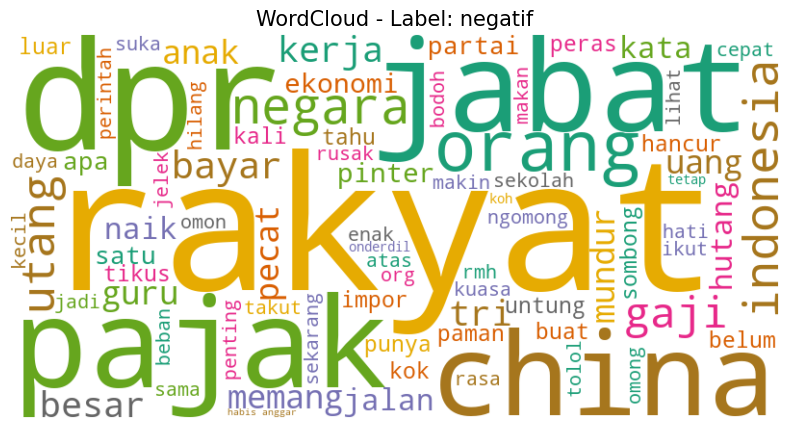

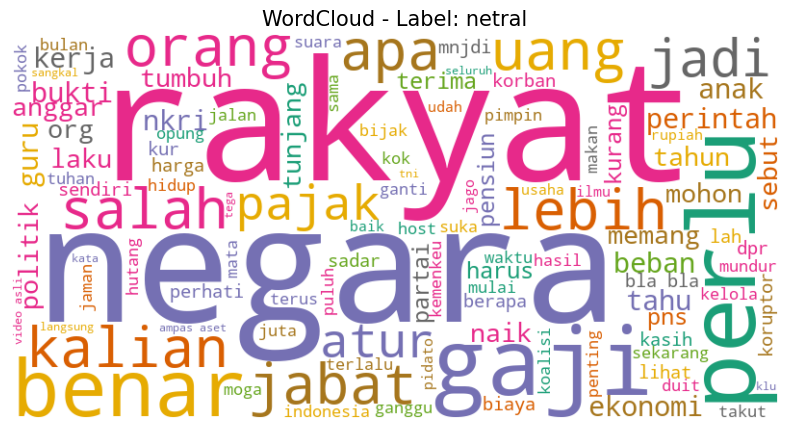

In [31]:
def generate_wordcloud(text_data, title):
    all_text = ' '.join(text_data)
    if len(all_text) == 0:
        return

    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='Dark2', min_font_size=10).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()


print("➤ WordCloud: Seluruh Data")
generate_wordcloud(manual_df['clean_text'], "WordCloud - General")

# WordCloud per Label
for label in manual_df['label'].unique():
    subset = manual_df[manual_df['label'] == label]['clean_text']
    generate_wordcloud(subset, f"WordCloud - Label: {label}")

In [32]:
# Pisahkan data Labeled (Manual) vs Unlabeled (Sisa Full Data)
labeled_texts = set(manual_df['text'].unique())
unlabeled_df = full_df[~full_df['text'].isin(labeled_texts)].copy()

print(f"Data Training: {len(manual_df)}")
print(f"Data Prediksi: {len(unlabeled_df)}")

# Split Train & Test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    manual_df['clean_text'], manual_df['label'],
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=manual_df['label']
)

# TF-IDF
print("\n➤ Extracting Features (TF-IDF)...")
vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

Data Training: 315
Data Prediksi: 1686

➤ Extracting Features (TF-IDF)...


In [33]:
print("TRAINING LINEAR SVC...")
model = LinearSVC(random_state=RANDOM_STATE, max_iter=2000)
model.fit(X_train_vec, y_train)

# Evaluasi
y_pred = model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print(f"\n✓ Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Cross Validation
print("➤ 5-Fold Cross Validation...")
X_all_vec = vectorizer.transform(manual_df['clean_text'])
cv_scores = cross_val_score(model, X_all_vec, manual_df['label'], cv=5)
print(f"✓ CV Mean Accuracy: {cv_scores.mean():.4f}")

TRAINING LINEAR SVC...

✓ Accuracy: 0.5397 (53.97%)

Classification Report:
               precision    recall  f1-score   support

     negatif       0.50      0.48      0.49        21
      netral       0.40      0.38      0.39        21
     positif       0.70      0.76      0.73        21

    accuracy                           0.54        63
   macro avg       0.53      0.54      0.54        63
weighted avg       0.53      0.54      0.54        63

➤ 5-Fold Cross Validation...
✓ CV Mean Accuracy: 0.4921


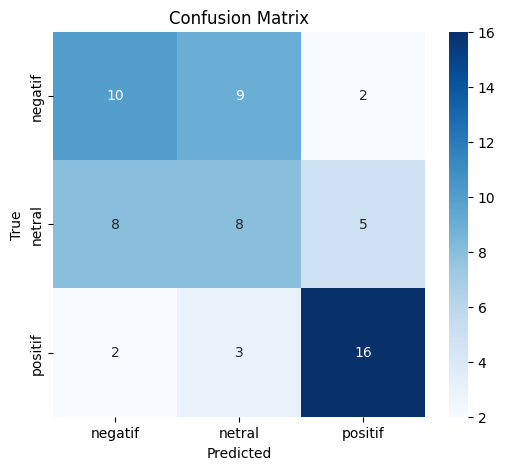

In [34]:
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
print("=" * 60)
print("PREDIKSI DATA UNLABELED & PENYIMPANAN")
print("=" * 60)

# 1. Prediksi Data Kosong
if len(unlabeled_df) > 0:
    print(f"➤ Memprediksi {len(unlabeled_df)} data baru...")
    X_unlabeled_vec = vectorizer.transform(unlabeled_df['clean_text'])
    predictions = model.predict(X_unlabeled_vec)

    unlabeled_df = unlabeled_df.copy()
    unlabeled_df['label'] = predictions
    unlabeled_df['source'] = 'auto-labeled'
else:
    print("⚠ Tidak ada data unlabeled.")

# 2. Gabung & Simpan
manual_df['source'] = 'manual'
# Merge dengan data full untuk mengambil metadata (date/tokoh)
manual_complete = pd.merge(
    manual_df, full_df[['text', 'date', 'tokoh']],
    on='text', how='left', suffixes=('', '_full')
).drop_duplicates(subset=['text'])

# Pilih kolom final
cols = ['date', 'tokoh', 'text', 'clean_text', 'label', 'source']
# Handle jika kolom date/tokoh tidak ada
final_cols = [c for c in cols if c in manual_complete.columns]

final_df = pd.concat([manual_complete[final_cols],
                     unlabeled_df[final_cols]], ignore_index=True)

final_df.to_csv('dataset_labeled_auto.csv', index=False)
print("✓ File disimpan: dataset_full_labeled.csv")

PREDIKSI DATA UNLABELED & PENYIMPANAN
➤ Memprediksi 1686 data baru...
✓ File disimpan: dataset_full_labeled.csv


ANALISIS KOMPARATIF: PURBAYA VS SRI MULYANI

Tabel Jumlah Sentimen:


label,negatif,netral,positif
tokoh,,,
Purbaya Yudhi Sadewa,283,352,373
Sri Mulyani Indrawati,394,373,226


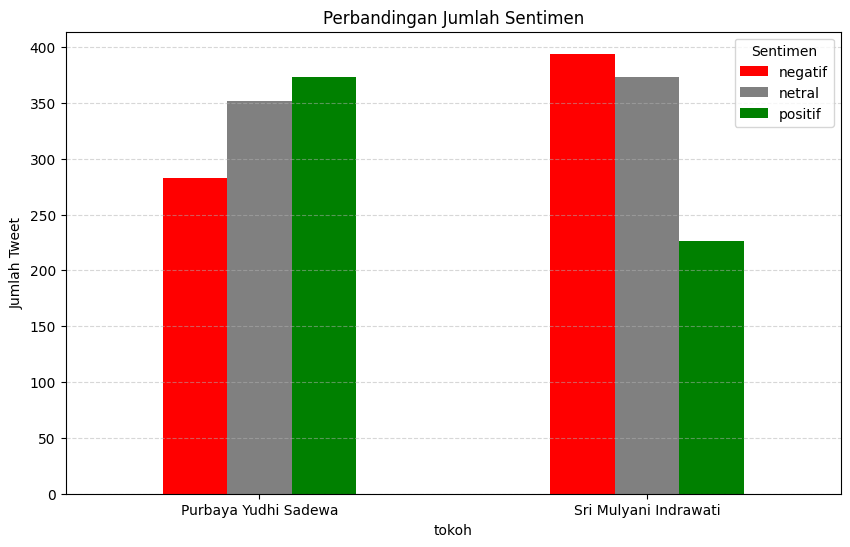

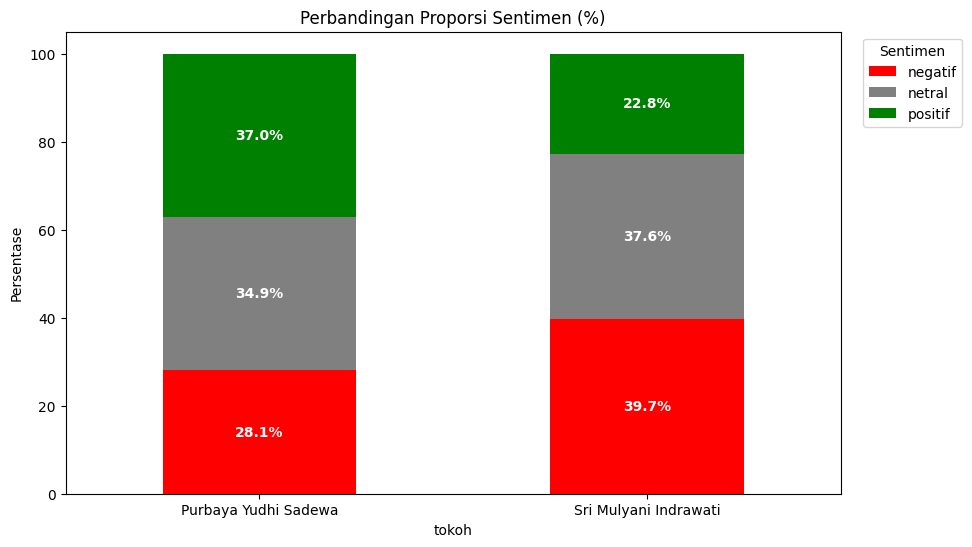

In [36]:
print("=" * 60)
print("ANALISIS KOMPARATIF: PURBAYA VS SRI MULYANI")
print("=" * 60)

# Pastikan menggunakan data hasil gabungan
df_viz = final_df.copy()

if 'tokoh' in df_viz.columns:
    # Buat Pivot Table
    comp = df_viz.groupby(['tokoh', 'label']).size().unstack(fill_value=0)

    print("\nTabel Jumlah Sentimen:")
    display(comp)

    # Hitung Persentase (Proporsi)
    comp_pct = comp.div(comp.sum(axis=1), axis=0) * 100

    # Visualisasi 1: Jumlah Absolut (Bar Chart)
    ax1 = comp.plot(kind='bar', figsize=(10, 6),
                    color=['red', 'gray', 'green'])
    plt.title('Perbandingan Jumlah Sentimen')
    plt.ylabel('Jumlah Tweet')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Sentimen')
    plt.show()

    # Visualisasi 2: Proporsi % (Stacked Bar 100%)
    ax2 = comp_pct.plot(kind='bar', stacked=True, figsize=(
        10, 6), color=['red', 'gray', 'green'])
    plt.title('Perbandingan Proporsi Sentimen (%)')
    plt.ylabel('Persentase')
    plt.xticks(rotation=0)
    plt.legend(title='Sentimen', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Tambahkan label angka % di dalam bar
    for c in ax2.containers:
        ax2.bar_label(c, fmt='%.1f%%', label_type='center',
                      color='white', fontsize=10, weight='bold')

    plt.show()
else:
    print("Kolom 'tokoh' tidak ditemukan. Pastikan dataset awal memiliki kolom tersebut.")